In [1]:
import torch
from torch import nn
import torchvision
from d2l import torch as d2l
import numpy as np
import csv
import random
from torch.utils.data import DataLoader, TensorDataset

net = nn.Sequential(
    nn.Linear(10, 24),nn.ReLU(),
    nn.Linear(24, 48),nn.ReLU(),
    nn.Linear(48, 24),nn.ReLU(),
    nn.Linear(24,5))

In [2]:
X = torch.rand(size=(100, 10), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Linear output shape: 	 torch.Size([100, 24])
ReLU output shape: 	 torch.Size([100, 24])
Linear output shape: 	 torch.Size([100, 48])
ReLU output shape: 	 torch.Size([100, 48])
Linear output shape: 	 torch.Size([100, 24])
ReLU output shape: 	 torch.Size([100, 24])
Linear output shape: 	 torch.Size([100, 5])


In [3]:
train = "../数据集/vessel_health.csv"
dataset=[]
labelset=[]

with open(train,'r',encoding='utf-8') as csvfile:
    csv_reader=csv.reader(csvfile)
    header=next(csv_reader)
    for row in csv_reader:
        labelset.append(row[0:5])
        dataset.append(row[5:15])
features=np.mat(dataset).astype(float)
labels=np.mat(labelset).astype(float)

features = torch.from_numpy(features)
labels = torch.from_numpy(labels)

features = features.float()
labels = labels.float()

dataset = TensorDataset(features, labels)

batch_size = 5
shuffle = True
num_workers = 2

train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
lr = 0.4
num_epochs = 100

In [4]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
        y = d2l.argmax(y, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

In [5]:
def train_ch(net, train_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MultiLabelSoftMarginLoss(reduction='mean')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.470, train acc 0.554
646.3 examples/sec on cuda:0


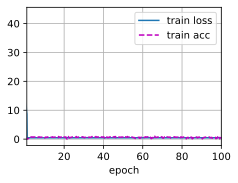

In [6]:
train_ch(net, train_iter, num_epochs, lr, d2l.try_gpu())

In [7]:
torch.save(net,'../model/model_vessel.pt')